># "WeRateDogs Wrangle & Analyze Data Project"
>###  By: Maged El-Soury

> <img style="float: left;" src="CT4udn0WwAA0aMy.jpg"/>

In [2]:
# Importing used libraries
import pandas as pd
import time
import numpy as np
import requests as r
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt

> ## PART I: Data Wrangling Process:
>- ### Gathering Data
>>- #### 1st Project Dataset --- > `twitter_archive_enhanced.csv`
>>- #### 2nd Project Dataset --- > `image_predictions.tsv`
>>- #### 3rd Project Dataset --- > `tweet_json.txt` (Additional Data via tweeter API)

In [3]:
# Reading a csv file and loading its content on a DataFrame using Pandas
file_name = "twitter-archive-enhanced.csv"
tw_archive_df = pd.read_csv(file_name)

In [4]:
# Downloading a tsv file programmatically using the Requests library
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = r.get(url)
# Loading the downloaded tsv file programmatically on a DataFrame using Pandas 
df_list = []
counter = 0
image_prediction = response.text
image_prediction_length = len(image_prediction.split("\n"))
for line in image_prediction:
    if counter == 0:
        col_name = image_prediction.split("\n")[counter].split("\t")
        counter += 1
    elif counter < image_prediction_length - 1:
        tweet_id = image_prediction.split("\n")[counter].split("\t")[0]
        jpg_url = image_prediction.split("\n")[counter].split("\t")[1]
        img_num = image_prediction.split("\n")[counter].split("\t")[2]
        p1 = image_prediction.split("\n")[counter].split("\t")[3]
        p1_conf = image_prediction.split("\n")[counter].split("\t")[4]
        p1_dog = image_prediction.split("\n")[counter].split("\t")[5]
        p2 = image_prediction.split("\n")[counter].split("\t")[6]
        p2_conf = image_prediction.split("\n")[counter].split("\t")[7]
        p2_dog = image_prediction.split("\n")[counter].split("\t")[8]
        p3 = image_prediction.split("\n")[counter].split("\t")[9]
        p3_conf = image_prediction.split("\n")[counter].split("\t")[10]
        p3_dog = image_prediction.split("\n")[counter].split("\t")[11]
        counter += 1
        df_list.append({col_name[0] : int(tweet_id), col_name[1] : jpg_url,
                        col_name[2] : int(img_num), col_name[3] : p1, 
                        col_name[4] : float(p1_conf), col_name[5] : p1_dog, 
                        col_name[6] : p2, col_name[7] : float(p2_conf),
                        col_name[8] : p2_dog, col_name[9] : p3,
                        col_name[10] : float(p3_conf), col_name[11] : p3_dog})
image_prediction_df = pd.DataFrame(df_list, columns = col_name)
# Writing the DataFrame on a tsv file on local drive
image_prediction_df.to_csv("image-predictions.tsv", sep = "\t", header = True, index = False)

```
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = tw_archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
```

In [5]:
# Reading txt file and loading JSON to a DataFrame
df_list = []
labels = ["tweet_id", "retweet_count", "favourite_count"]
with open("tweet_json.txt", encoding = "utf-8") as text_file_handler:
    json_text_file_lines_length = len(text_file_handler.readlines())
with open("tweet_json.txt", encoding = "utf-8") as text_file_handler:
    for i in range(json_text_file_lines_length):
        line_list = text_file_handler.readline().split(",")
        tweet_id = int(line_list[1].split(":")[1])
        for index, word in enumerate(line_list):
            if "retweet_count" in word:
                retweet_count = int(line_list[index].split(":")[1])
                favourite_count = int(line_list[index + 1].split(":")[1])
        df_list.append({labels[0] : tweet_id, labels[1] : retweet_count, labels[2] : favourite_count})
tw_api_df = pd.DataFrame(df_list, columns = labels)
# Writing the DataFrame on a tsv file on local drive
tw_api_df.to_csv("tweeter-api.tsv", sep = "\t", header = True, index = False)

> ## PART I: Data Wrangling Process:
>- ### Assessing Data 
>> ### DataFrames
>>- #### 1st DataFrame --- > `tw_archive_df`
>>- #### 2nd DataFrame --- > `image_prediction_df`
>>- #### 3rd DataFrame --- > `tw_api_df` 

- `tw_archive_df` ---> Visual Assessment

In [6]:
tw_archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [7]:
tw_archive_df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
849,766008592277377025,NaN,NaN,2016-08-17 20:27:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Angel. She stole the @ShopWeRateDogs s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/766008592...,11,10,Angel,None,None,None,None
1494,692568918515392513,NaN,NaN,2016-01-28 04:44:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chester. He's been guarding this pumpk...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692568918...,12,10,Chester,None,None,None,None
104,872261713294495745,NaN,NaN,2017-06-07 01:19:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Harry. His ears are activated one at a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872261713...,13,10,Harry,None,None,None,None
397,825120256414846976,NaN,NaN,2017-01-27 23:16:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to Pablo. He's one go...,8.250266e+17,4.196984e+09,2017-01-27 17:04:02 +0000,https://www.gofundme.com/my-puppys-double-cata...,12,10,Pablo,None,None,None,puppo
929,754482103782404096,NaN,NaN,2016-07-17 01:05:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Milo. He's currently plotting his reve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/754482103...,10,10,Milo,None,None,None,None
2072,671109016219725825,NaN,NaN,2015-11-29 23:30:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Toby. He asked for chocolate cake for ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671109016...,8,10,Toby,None,None,None,None
1888,674781762103414784,NaN,NaN,2015-12-10 02:44:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Bedazzled pup here. Fashionable af. Super yell...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674781762...,8,10,None,None,None,None,None
947,752519690950500352,NaN,NaN,2016-07-11 15:07:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Hopefully this puppo on a swing will help get ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/752519690...,11,10,None,None,None,None,puppo
560,802952499103731712,NaN,NaN,2016-11-27 19:09:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Marley. She's having a ruff day. Prett...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/802952499...,12,10,Marley,None,None,None,None
1107,734776360183431168,NaN,NaN,2016-05-23 16:01:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Livvie. Someone should tell her it's b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/734776360...,11,10,Livvie,None,None,None,None


In [8]:
tw_archive_df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1752,678969228704284672,NaN,NaN,2015-12-21 16:04:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Lola. She's a Metamorphic Chartreuse. Pla...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678969228...,11,10,Lola,None,None,None,None
1690,681339448655802368,NaN,NaN,2015-12-28 05:02:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Asher. He's not wearing a seatbelt or ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681339448...,9,10,Asher,None,None,None,None
247,845459076796616705,NaN,NaN,2017-03-25 02:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Here's a heartwarming scene of ...,7.562885e+17,4.196984e+09,2016-07-22 00:43:32 +0000,https://twitter.com/dog_rates/status/756288534...,12,10,None,None,None,None,None
1544,689517482558820352,NaN,NaN,2016-01-19 18:39:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Carl. He just wants to make sure you'r...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/689517482...,12,10,Carl,None,None,None,None
1671,682393905736888321,NaN,NaN,2015-12-31 02:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kreg. He's riding an invisible jet ski...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682393905...,11,10,Kreg,None,None,None,None
739,780601303617732608,NaN,NaN,2016-09-27 02:53:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Hercules. He can have whatever he wants f...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/780601303...,12,10,Hercules,None,None,None,None
2187,668979806671884288,NaN,NaN,2015-11-24 02:29:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chaz. He's an X Games half pipe supers...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668979806...,12,10,Chaz,None,None,None,None
1219,714631576617938945,NaN,NaN,2016-03-29 01:53:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Benedict. He's a feisty pup. Needs a b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/714631576...,4,10,Benedict,None,None,None,None
2043,671536543010570240,NaN,NaN,2015-12-01 03:49:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Reginald. He's pondering what life wou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671536543...,9,10,Reginald,None,None,None,None
711,784517518371221505,NaN,NaN,2016-10-07 22:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Frankie. He has yet to learn how to co...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/784517518...,11,10,Frankie,None,None,None,None


- `tw_archive_df` ---> Programmatically Assessment

In [9]:
tw_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
tw_archive_df.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
          ... 
Crumpet      1
Kulet        1
Zoe          1
Ole          1
William      1
Name: name, Length: 957, dtype: int64

In [11]:
tw_archive_df.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [12]:
tw_archive_df[tw_archive_df.doggo == "doggo"].sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo
323,834089966724603904,NaN,NaN,2017-02-21 17:18:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",DOGGO ON THE LOOSE I REPEAT DOGGO ON THE LOOSE...,NaN,NaN,NaN,https://twitter.com/stevekopack/status/8340866...,10,10,None,doggo,None,None,None
992,748692773788876800,NaN,NaN,2016-07-01 01:40:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",That is Quizno. This is his beach. He does not...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748692773...,10,10,his,doggo,None,None,None
1063,741067306818797568,NaN,NaN,2016-06-10 00:39:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is just downright precious af. 12/10 for ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo,None,pupper,None
248,845397057150107648,NaN,NaN,2017-03-24 22:08:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Mimosa. She's an emotional suppor...,NaN,NaN,NaN,"https://www.gofundme.com/help-save-a-pup,https...",13,10,Mimosa,doggo,None,None,None
300,836753516572119041,NaN,NaN,2017-03-01 01:42:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Meera. She just heard about taxes and ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/836753516...,12,10,Meera,doggo,None,None,None
914,757393109802180609,NaN,NaN,2016-07-25 01:52:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo completely oblivious to the dou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/757393109...,10,10,None,doggo,None,None,None
429,821107785811234820,NaN,NaN,2017-01-16 21:32:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo who looks like he's about to gi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/821107785...,11,10,None,doggo,None,None,None
211,851953902622658560,NaN,NaN,2017-04-12 00:23:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Astrid. She's a guide d...,8.293743e+17,4.196984e+09,2017-02-08 17:00:26 +0000,https://twitter.com/dog_rates/status/829374341...,13,10,Astrid,doggo,None,None,None
746,780074436359819264,NaN,NaN,2016-09-25 16:00:13 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here's a doggo questioning his entire existenc...,NaN,NaN,NaN,https://vine.co/v/5nzYBpl0TY2,10,10,None,doggo,None,None,None


In [13]:
tw_archive_df.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [14]:
tw_archive_df.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [15]:
tw_archive_df.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [16]:
tw_archive_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
0         2
15        2
75        2
420       2
182       1
204       1
143       1
121       1
99        1
20        1
45        1
27        1
17        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
1776      1
960       1
666       1
144       1
165       1
Name: rating_numerator, dtype: int64

In [17]:
sum(tw_archive_df.rating_numerator.value_counts())

2356

In [18]:
tw_archive_df.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

In [19]:
dog_name_freq_dict = tw_archive_df.name.value_counts().to_dict()
dog_name_freq_key_list = tw_archive_df.name.value_counts().index.tolist()
dog_name_freq_value_list = tw_archive_df.name.value_counts().tolist()
for index, dog in enumerate(dog_name_freq_key_list):
    if dog.istitle() != True:
        print(index, dog, dog_name_freq_dict[dog])
        if dog_name_freq_dict[dog] <= 8:
            df_index_list = tw_archive_df[tw_archive_df.name == dog].index.tolist()
            for index in df_index_list:
                print(tw_archive_df.loc[index, "text"])
                

1 a 55
11 the 8
Stop sending in lobsters. This is the final warning. We only rate dogs. Thank you... 9/10 https://t.co/B9ZXXKJYNx
This is the newly formed pupper a capella group. They're just starting out but I see tons of potential. 8/10 for all https://t.co/wbAcvFoNtn
This is the happiest pupper I've ever seen. 10/10 would trade lives with https://t.co/ep8ATEJwRb
This is the saddest/sweetest/best picture I've been sent. 12/10 😢🐶 https://t.co/vQ2Lw1BLBF
This is the best thing I've ever seen so spread it like wildfire &amp; maybe we'll find the genius who created it. 13/10 https://t.co/q6RsuOVYwU
Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3
This is the happiest dog you will ever see. Very committed owner. Nice couch. 10/10 https://t.co/RhUEAloehK
Here is the Rand Paul of retrievers folks! He's probably good at poker. Can drink beer (lol rad). 8/10 good dog https://t.co/pYAJkAe76p
13 an 7
RT @dog_r

- `image_prediction_df` ---> Visual Assessment

In [20]:
image_prediction_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [21]:
image_prediction_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
292,671186162933985280,https://pbs.twimg.com/media/CVCIQX7UkAEzqh_.jpg,1,Chihuahua,0.319106,True,whippet,0.169134,True,toy_terrier,0.125815,True
960,705786532653883392,https://pbs.twimg.com/media/Cct1G6vVAAI9ZjF.jpg,1,web_site,0.550294,False,Labrador_retriever,0.148496,True,golden_retriever,0.148482,True
1470,779123168116150273,https://pbs.twimg.com/media/CtAAYizW8AAWzBZ.jpg,1,toy_poodle,0.431080,True,soft-coated_wheaten_terrier,0.060365,True,cocker_spaniel,0.059845,True
1723,819924195358416896,https://pbs.twimg.com/ext_tw_video_thumb/81992...,1,bathtub,0.100896,False,shower_curtain,0.091866,False,tub,0.049176,False
1919,855851453814013952,https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg,1,flat-coated_retriever,0.321676,True,Labrador_retriever,0.115138,True,groenendael,0.096100,True
227,670374371102445568,https://pbs.twimg.com/media/CU2l7yvXAAUyYIJ.jpg,1,English_springer,0.974936,True,English_setter,0.011661,True,cocker_spaniel,0.002689,True
1807,832397543355072512,https://pbs.twimg.com/media/C41FIiAW8AA7lMr.jpg,1,Pekinese,0.988916,True,Brabancon_griffon,0.001677,True,Siamese_cat,0.001126,False
736,687102708889812993,https://pbs.twimg.com/media/CYkURJjW8AEamoI.jpg,1,fiddler_crab,0.992069,False,quail,0.002491,False,rock_crab,0.001513,False
1080,718234618122661888,https://pbs.twimg.com/media/CfeukpmW4AEGjOE.jpg,1,malamute,0.370152,True,Siberian_husky,0.356398,True,Eskimo_dog,0.271042,True
1790,830097400375152640,https://pbs.twimg.com/media/C4UZLZLWYAA0dcs.jpg,4,toy_poodle,0.442713,True,Pomeranian,0.142073,True,Pekinese,0.125745,True


In [22]:
image_prediction_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1747,823322678127919110,https://pbs.twimg.com/media/C20HmaKWgAQ6-6X.jpg,2,cowboy_boot,0.990253,False,Chihuahua,0.001836,True,papillon,0.001274,True
187,669367896104181761,https://pbs.twimg.com/media/CUoSjTnWwAANNak.jpg,1,basset,0.749394,True,beagle,0.133579,True,Welsh_springer_spaniel,0.030198,True
1020,710153181850935296,https://pbs.twimg.com/media/Cdr4jO2UAAAIo6W.jpg,2,cowboy_hat,0.979053,False,sombrero,0.010683,False,cocker_spaniel,0.002713,True
2063,889880896479866881,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,1,French_bulldog,0.377417,True,Labrador_retriever,0.151317,True,muzzle,0.082981,False
624,680609293079592961,https://pbs.twimg.com/media/CXICiB9UwAE1sKY.jpg,1,French_bulldog,0.700764,True,Chihuahua,0.072390,True,American_Staffordshire_terrier,0.039619,True
1076,717421804990701568,https://pbs.twimg.com/media/CfTLUYWXEAEkyES.jpg,2,miniature_pinscher,0.286479,True,Italian_greyhound,0.084134,True,beagle,0.064697,True
1517,787322443945877504,https://pbs.twimg.com/media/Cu0hlfwWYAEdnXO.jpg,1,seat_belt,0.747739,False,golden_retriever,0.105703,True,dingo,0.017257,False
233,670420569653809152,https://pbs.twimg.com/media/CU3P82RWEAAIVrE.jpg,1,bow_tie,0.268759,False,cardigan,0.153957,False,wig,0.072295,False
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,golden_retriever,0.775930,True,Tibetan_mastiff,0.093718,True,Labrador_retriever,0.072427,True
500,675845657354215424,https://pbs.twimg.com/media/CWEWClfW4AAnqhG.jpg,1,pug,0.883952,True,Boston_bull,0.011057,True,French_bulldog,0.009840,True


- `image_prediction_df` ---> Programmatically Assessment

In [23]:
image_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   object 
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   object 
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   object 
dtypes: float64(3), int64(2), object(7)
memory usage: 194.7+ KB


In [24]:
 image_prediction_df.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [25]:
p1_dog_df = image_prediction_df[image_prediction_df.p1_dog == "True"]
p1_conf_max = max(p1_dog_df.p1_conf)
p1_conf_min = min(p1_dog_df.p1_conf)
print(p1_conf_min, p1_conf_max)

0.0443334 0.999956


In [26]:
 image_prediction_df.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [27]:
p2_dog_df = image_prediction_df[image_prediction_df.p2_dog == "True"]
p2_conf_max = max(p2_dog_df.p2_conf)
p2_conf_min = min(p2_dog_df.p2_conf)
print(p2_conf_min, p2_conf_max)

1.00288e-05 0.467678


In [28]:
 image_prediction_df.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [29]:
p3_dog_df = image_prediction_df[image_prediction_df.p3_dog == "True"]
p3_conf_max = max(p3_dog_df.p3_conf)
p3_conf_min = min(p3_dog_df.p3_conf)
print(p3_conf_min, p3_conf_max)

1.43447e-06 0.273419


In [30]:
p1_dog_df = image_prediction_df[(image_prediction_df.p1_dog == "True")&(image_prediction_df.p1_conf >= 0.6)]
p1_dog_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,golden_retriever,0.775930,True,Tibetan_mastiff,0.093718,True,Labrador_retriever,0.072427,True
20,666287406224695296,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,1,Maltese_dog,0.857531,True,toy_poodle,0.063064,True,miniature_poodle,0.025581,True
23,666345417576210432,https://pbs.twimg.com/media/CT9Vn7PWoAA_ZCM.jpg,1,golden_retriever,0.858744,True,Chesapeake_Bay_retriever,0.054787,True,Labrador_retriever,0.014241,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2060,889531135344209921,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,1,golden_retriever,0.953442,True,Labrador_retriever,0.013834,True,redbone,0.007958,True
2061,889638837579907072,https://pbs.twimg.com/media/DFihzFfXsAYGDPR.jpg,1,French_bulldog,0.991650,True,boxer,0.002129,True,Staffordshire_bullterrier,0.001498,True
2062,889665388333682689,https://pbs.twimg.com/media/DFi579UWsAAatzw.jpg,1,Pembroke,0.966327,True,Cardigan,0.027356,True,basenji,0.004633,True
2064,890006608113172480,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1,Samoyed,0.957979,True,Pomeranian,0.013884,True,chow,0.008167,True


In [31]:
p1_dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795 entries, 5 to 2072
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  795 non-null    int64  
 1   jpg_url   795 non-null    object 
 2   img_num   795 non-null    int64  
 3   p1        795 non-null    object 
 4   p1_conf   795 non-null    float64
 5   p1_dog    795 non-null    object 
 6   p2        795 non-null    object 
 7   p2_conf   795 non-null    float64
 8   p2_dog    795 non-null    object 
 9   p3        795 non-null    object 
 10  p3_conf   795 non-null    float64
 11  p3_dog    795 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 80.7+ KB


In [32]:
p2_conf_max = max(p1_dog_df.p2_conf)
p2_conf_min = min(p1_dog_df.p2_conf)
print(p2_conf_min, p2_conf_max)
p1_dog_df.p2_dog.value_counts()

2.3359099999999998e-05 0.38133


True     744
False     51
Name: p2_dog, dtype: int64

In [33]:
p3_conf_max = max(p1_dog_df.p3_conf)
p3_conf_min = min(p1_dog_df.p3_conf)
print(p3_conf_min, p3_conf_max)
p1_dog_df.p3_dog.value_counts()

2.1609000000000002e-07 0.179107


True     702
False     93
Name: p3_dog, dtype: int64

- `tw_api_df` ---> Visual Assessment

In [34]:
tw_api_df

,tweet_id,retweet_count,favourite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


In [35]:
tw_api_df.sample(10)

,tweet_id,retweet_count,favourite_count
363,829141528400556032,8530,26952
338,832273440279240704,2673,12385
1850,675707330206547968,771,2154
1771,678255464182861824,418,1726
203,852936405516943360,2243,0
1216,714957620017307648,1595,4503
1345,704364645503647744,3999,8804
354,830956169170665475,1735,8735
1758,678708137298427904,2753,6082
786,774639387460112384,2013,7508


- `tw_api_df` ---> Programmatically Assessment

In [36]:
tw_api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   tweet_id         2354 non-null   int64
 1   retweet_count    2354 non-null   int64
 2   favourite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [37]:
tw_api_df.retweet_count.value_counts()

3652    5
1972    5
83      5
819     4
115     4
       ..
1526    1
230     1
1522    1
5616    1
7       1
Name: retweet_count, Length: 1724, dtype: int64

In [38]:
tw_api_df.retweet_count.value_counts().index

Int64Index([3652, 1972,   83,  819,  115,  516,  542,  577,   71,  336,
            ...
            1552, 3599,  754, 3583, 1530, 1526,  230, 1522, 5616,    7],
           dtype='int64', length=1724)

In [39]:
min(tw_api_df.retweet_count.value_counts().index)

0

In [40]:
max(tw_api_df.retweet_count.value_counts().index)

79515

In [41]:
tw_api_df.favourite_count.value_counts()

0        179
2918       3
2706       3
2768       3
1691       3
        ... 
7493       1
5444       1
5442       1
7489       1
24574      1
Name: favourite_count, Length: 2007, dtype: int64

In [42]:
tw_api_df.favourite_count.value_counts().index

Int64Index([    0,  2918,  2706,  2768,  1691,  1339,   345,  2176,   610,
             3593,
            ...
             3415, 41080, 36177,  1356,  7495,  7493,  5444,  5442,  7489,
            24574],
           dtype='int64', length=2007)

In [43]:
min(tw_api_df.favourite_count.value_counts().index)

0

In [44]:
max(tw_api_df.favourite_count.value_counts().index)

132810

##### Quality
> #### `tw_archive_df` DataFrame
>> - column name to be dog_name
>> - column name (dog_name) values None to NaN. 
>> - column name (dog_name) lower values to be checked and corrected either to its name or NaN value.
>> - column name (dog_name) Title values to be checked and corrected either to its name or NaN value.
>> - columns doggo, floofer, pupper, puppo values None to NaN.
>> - columns doggo, floofer, pupper, puppo values to be checked and corrected as possible.
>> - in_reply_to_statuts_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id are int not a float
>> - timestamp is Datetime not string
>> - column rating_numerator is float not int and values to checked  from text and corrected as possible
     eg: dog_name == space, and rating_numerator count <= 9
     
> #### `image_prediction_df` DataFrame
>> - column p1 to be image_prediction_algorithm_1_result similarly p2 and p3 columns
>> - column p1 values are mix of lower case strings or titled strings to be modified to titled strings 
>> - column p1_conf to be image_prediction_algorithm_1_confidence_interval similarly p2_conf and p3_conf columns 
>> - column p1_dog to be is_algorithm_1_result_dog_breed similarly p2_dog and p3_dog columns.

##### Tidiness
> #### `tw_archive_df` DataFrame
>> - columns doggo, floofer, pupper, puppo  to be melted in one column named dog_stage.

> #### `image_prediction_df` DataFrame
>> - columns p2, p3, p2_conf, p3_conf, p2_dog and p3_dog to be dropped under 
     the constrain that p1 confidence interval >= 0.6 and p1_dog = "True"

> #### DataFrames Merging
>> - `image_prediction_df` to be merged with `tw_api_df` and `tw_archive_df`

> #### Resultant DataFrame to be Filtered according to:
>> - `jpg_url` and `retweeted_status_id != NaN` rows to be dropped
.. - columns `in_reply_to_status_id`, `in_reply_to_user_id`, `source`, `expanded_urls` to be dropped

> ## PART I: Data Wrangling Process:
>- ### Cleaning Data 

- Copying DataFrames

In [45]:
tw_archive_df_clean = tw_archive_df.copy()
image_prediction_df_clean = image_prediction_df.copy()
tw_api_df_clean = tw_api_df.copy()

>- ### Tidiness

##### Define:
- Dropping columns p2, p3, p2_conf, p3_conf, p2_dog and p3_dog of `image_prediction_df` DataFrame under 
     the constrain that p1 confidence interval >= 0.6 and p1_dog = "True"

##### Coding:

In [46]:
image_prediction_df_clean = image_prediction_df_clean[(image_prediction_df_clean.p1_dog == "True")&(image_prediction_df_clean.p1_conf >= 0.6)]
image_prediction_df_clean.drop(["p2", "p2_conf", "p2_dog", "p3", "p3_conf", "p3_dog"], axis = 1,  inplace = True)

##### Testing:

In [47]:
image_prediction_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795 entries, 5 to 2072
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  795 non-null    int64  
 1   jpg_url   795 non-null    object 
 2   img_num   795 non-null    int64  
 3   p1        795 non-null    object 
 4   p1_conf   795 non-null    float64
 5   p1_dog    795 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 43.5+ KB


In [48]:
image_prediction_df_clean.p1_dog.value_counts()

True    795
Name: p1_dog, dtype: int64

In [49]:
print("Min = {}".format(min(image_prediction_df_clean.p1_conf.value_counts().index)) + "\n" + "Max = {}".format(max(image_prediction_df_clean.p1_conf.value_counts().index)))

Min = 0.600186
Max = 0.999956


##### Define:
- Merging `image_prediction_df`(Filtered) with `tw_api_df` and `tw_archive_df` to be Filtered also, merging using `tweet_id`

##### Coding:

In [50]:
tw_archive_master = pd.merge(image_prediction_df_clean, tw_api_df_clean, on = "tweet_id")

##### Testing:

In [51]:
tw_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794 entries, 0 to 793
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_id         794 non-null    int64  
 1   jpg_url          794 non-null    object 
 2   img_num          794 non-null    int64  
 3   p1               794 non-null    object 
 4   p1_conf          794 non-null    float64
 5   p1_dog           794 non-null    object 
 6   retweet_count    794 non-null    int64  
 7   favourite_count  794 non-null    int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 55.8+ KB


### Wrangling Assessment Updated
##### Quality 
> #### `tw_archive_df` DataFrame
>> - column name to be dog_name
>> - column name (dog_name) values None to NaN. 
>> - column name (dog_name) lower values to be checked and corrected either to its name or NaN value.
>> - column name (dog_name) Title values to be checked and corrected either to its name or NaN value.
>> - columns doggo, floofer, pupper, puppo values None to NaN.
>> - columns doggo, floofer, pupper, puppo values to be checked and corrected as possible.
>> - in_reply_to_statuts_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id are int not a float
>> - timestamp is Datetime not string
>> - column rating_numerator is float not int and values to checked  from text and corrected as possible
     eg: dog_name == space, and rating_numerator count <= 9
     
> #### `tw_archive_master` DataFrame
>> - column p1 to be image_prediction_algorithm_1_result
>> - column p1 values are mix of lower case strings or titled strings to be modified to titled strings
>> - column p1_conf to be image_prediction_algorithm_1_confidence_interval 
>> - column p1_dog to be is_algorithm_1_result_dog_breed

##### Tidiness
> #### `tw_archive_df` DataFrame
>> - columns doggo, floofer, pupper, puppo  to be melted in one column named dog_stage.

> #### DataFrames Merging
>> - `tw_archive_master` to be merged with `tw_archive_df`

> #### Resultant DataFrame to be Filtered according to:
>> - `jpg_url` and `retweeted_status_id != NaN` rows to be dropped
.. - columns `in_reply_to_status_id`, `in_reply_to_user_id`, `source`, `expanded_urls` to be dropped

>- ### Quality

##### Define:
`tw_archive_master` DataFrame
- change column p1 name to be dog_breed_image_prediction_result
- change column p1_conf name to be dog_breed_image_prediction_confidence_interval
- change column p1_dog name to be is_algorithm_1_result_dog_breed
- column p1 values are mix of lower case strings or titled strings to be modified to titled strings

##### Coding:

In [52]:
tw_archive_master = tw_archive_master.rename(columns={"p1" : "dog_breed_image_prediction_result", "p1_conf" : "dog_breed_image_prediction_confidence_interval", "p1_dog" : "is_image_prediction_result_a_dog_breed"})
tw_archive_master.dog_breed_image_prediction_result = tw_archive_master.dog_breed_image_prediction_result.str.title()

##### Testing:

In [53]:
tw_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794 entries, 0 to 793
Data columns (total 8 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   tweet_id                                        794 non-null    int64  
 1   jpg_url                                         794 non-null    object 
 2   img_num                                         794 non-null    int64  
 3   dog_breed_image_prediction_result               794 non-null    object 
 4   dog_breed_image_prediction_confidence_interval  794 non-null    float64
 5   is_image_prediction_result_a_dog_breed          794 non-null    object 
 6   retweet_count                                   794 non-null    int64  
 7   favourite_count                                 794 non-null    int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 55.8+ KB


In [54]:
tw_archive_master

,tweet_id,jpg_url,img_num,dog_breed_image_prediction_result,dog_breed_image_prediction_confidence_interval,is_image_prediction_result_a_dog_breed,retweet_count,favourite_count
0,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_Mountain_Dog,0.651137,True,60,136
1,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,Chow,0.692517,True,261,448
2,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,Golden_Retriever,0.775930,True,232,496
3,666287406224695296,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,1,Maltese_Dog,0.857531,True,71,152
4,666345417576210432,https://pbs.twimg.com/media/CT9Vn7PWoAA_ZCM.jpg,1,Golden_Retriever,0.858744,True,146,307
...,...,...,...,...,...,...,...,...
789,889531135344209921,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,1,Golden_Retriever,0.953442,True,2321,15359
790,889638837579907072,https://pbs.twimg.com/media/DFihzFfXsAYGDPR.jpg,1,French_Bulldog,0.991650,True,4735,27672
791,889665388333682689,https://pbs.twimg.com/media/DFi579UWsAAatzw.jpg,1,Pembroke,0.966327,True,8538,38818
792,890006608113172480,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1,Samoyed,0.957979,True,7624,31166


### Wrangling Assessment Updated
##### Quality 
> #### `tw_archive_df` DataFrame
>> - column name to be dog_name
>> - column name (dog_name) values None to NaN. 
>> - column name (dog_name) lower values to be checked and corrected either to its name or NaN value.
>> - column name (dog_name) Title values to be checked and corrected either to its name or NaN value.
>> - columns doggo, floofer, pupper, puppo values None to NaN.
>> - columns doggo, floofer, pupper, puppo values to be checked and corrected as possible.
>> - in_reply_to_statuts_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id are int not a float
>> - timestamp is Datetime not string
>> - column rating_numerator is float not int and values to checked  from text and corrected as possible
     eg: dog_name == space, and rating_numerator count <= 9    

##### Tidiness
> #### `tw_archive_df` DataFrame
>> - columns doggo, floofer, pupper, puppo  to be melted in one column named dog_stage.

> #### DataFrames Merging
>> - `tw_archive_master` to be merged with `tw_archive_df`

> #### Resultant DataFrame to be Filtered according to:
>> - `jpg_url` and `retweeted_status_id != NaN` rows to be dropped
.. - columns `in_reply_to_status_id`, `in_reply_to_user_id`, `source`, `expanded_urls` to be dropped

>- ### Tidiness & Quality

##### Define:
`tw_archive_df` DataFrame
- convert column name (dog_name) values None to NaN. 
- convert columns doggo, floofer, pupper, puppo values None to NaN.
- melt columns doggo, floofer, pupper, puppo   in one column named dog_stage.
- convert column name to be dog_name

##### Coding:

In [55]:
for col_name in ["name", "doggo", "floofer", "pupper", "puppo"]:
    tw_archive_df_clean[col_name].replace("None", np.nan, inplace=True)
tw_archive_df_clean = pd.melt(tw_archive_df_clean, id_vars = ["tweet_id", "in_reply_to_status_id", "in_reply_to_user_id", "timestamp", "source", "text", "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp", "expanded_urls", "rating_numerator", "rating_denominator", "name"], var_name = "dog_stage", value_name = "dog_stage_name")
tw_archive_df_clean = tw_archive_df_clean[tw_archive_df_clean.dog_stage_name.notna()]
tw_archive_df_clean = tw_archive_df_clean.drop("dog_stage", axis = 1)
tw_archive_df_clean = tw_archive_df_clean.rename(columns={"name" : "dog_name"})

##### Testing:

In [56]:
tw_archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 9 to 8151
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    394 non-null    int64  
 1   in_reply_to_status_id       9 non-null      float64
 2   in_reply_to_user_id         9 non-null      float64
 3   timestamp                   394 non-null    object 
 4   source                      394 non-null    object 
 5   text                        394 non-null    object 
 6   retweeted_status_id         38 non-null     float64
 7   retweeted_status_user_id    38 non-null     float64
 8   retweeted_status_timestamp  38 non-null     object 
 9   expanded_urls               388 non-null    object 
 10  rating_numerator            394 non-null    int64  
 11  rating_denominator          394 non-null    int64  
 12  dog_name                    226 non-null    object 
 13  dog_stage_name              394 no

### Wrangling Assessment Updated
##### Quality 
> #### `tw_archive_df` DataFrame
>> - column name (dog_name) lower values to be checked and corrected either to its name or NaN value.
>> - column name (dog_name) Title values to be checked and corrected either to its name or NaN value.
>> - columns doggo, floofer, pupper, puppo values to be checked and corrected as possible.
>> - in_reply_to_statuts_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id are int not a float
>> - timestamp is Datetime not string
>> - column rating_numerator is float not int and values to checked  from text and corrected as possible
     eg: dog_name == space, and rating_numerator count <= 9    

##### Tidiness
> #### DataFrames Merging
>> - `tw_archive_master` to be merged with `tw_archive_df`

> #### Resultant DataFrame to be Filtered according to:
>> - `jpg_url` and `retweeted_status_id != NaN` rows to be dropped
>> - columns `in_reply_to_status_id`, `in_reply_to_user_id`, `source`, `expanded_urls` to be dropped

>- ### Tidiness

##### Define:
- merge `tw_archive_master`  with `tw_archive_df` 
- drop rows according to the following criteria`jpg_url == NaN` and `retweeted_status_id != NaN` 
- drop the following columns `in_reply_to_status_id`, `in_reply_to_user_id`, `source`, `expanded_urls`

##### Coding:

In [57]:
tw_archive_master = pd.merge(tw_archive_df_clean, tw_archive_master, on = "tweet_id")
tw_archive_master = tw_archive_master[tw_archive_master.retweeted_status_id.isna()]
tw_archive_master = tw_archive_master.drop(["in_reply_to_status_id", "in_reply_to_user_id", "source", "expanded_urls"], axis = 1)


##### Testing:

In [58]:
tw_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 143
Data columns (total 17 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   tweet_id                                        138 non-null    int64  
 1   timestamp                                       138 non-null    object 
 2   text                                            138 non-null    object 
 3   retweeted_status_id                             0 non-null      float64
 4   retweeted_status_user_id                        0 non-null      float64
 5   retweeted_status_timestamp                      0 non-null      object 
 6   rating_numerator                                138 non-null    int64  
 7   rating_denominator                              138 non-null    int64  
 8   dog_name                                        87 non-null     object 
 9   dog_stage_name                             

### Wrangling Assessment Updated
##### Quality 
> #### `tw_archive_master` DataFrame
>> - column name (dog_name) lower values to be checked and corrected either to its name or NaN value.
>> - column name (dog_name) Title values to be checked and corrected either to its name or NaN value.
>> - columns doggo, floofer, pupper, puppo values to be checked and corrected as possible.
>> - in_reply_to_statuts_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id are int not a float
>> - timestamp is Datetime not string
>> - column rating_numerator is float not int and values to checked  from text and corrected as possible
     eg: dog_name == space, and rating_numerator count <= 9    

##### Tidiness
> #### `tw_archive_master` Resultant DataFrame to be Filtered according to:
>> - columns `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` to be dropped

>- ### Tidiness & Quality

##### Define:
- change in_reply_to_statuts_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id (need not to be done)
- drop columns `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` 

##### Coding:

In [59]:
tw_archive_master = tw_archive_master.drop(["retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"], axis = 1)

##### Testing:

In [60]:
tw_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 143
Data columns (total 14 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   tweet_id                                        138 non-null    int64  
 1   timestamp                                       138 non-null    object 
 2   text                                            138 non-null    object 
 3   rating_numerator                                138 non-null    int64  
 4   rating_denominator                              138 non-null    int64  
 5   dog_name                                        87 non-null     object 
 6   dog_stage_name                                  138 non-null    object 
 7   jpg_url                                         138 non-null    object 
 8   img_num                                         138 non-null    int64  
 9   dog_breed_image_prediction_result          

### Wrangling Assessment Updated
##### Quality 
> #### `tw_archive_master` DataFrame
>> - column name (dog_name) lower values to be checked and corrected either to its name or NaN value.
>> - column name (dog_name) Title values to be checked and corrected either to its name or NaN value.
>> - columns doggo, floofer, pupper, puppo values to be checked and corrected as possible.
>> - timestamp is Datetime not string
>> - column rating_numerator is float not int and values to checked  from text and corrected as possible
     eg: dog_name == space, and rating_numerator count <= 9    

>- ### Quality

##### Define:
#### `tw_archive_master` DataFrame
- check and correct column name (dog_name) lower values to be its name or NaN value.
- check and correct column name (dog_name) Title values to be its name or NaN value.
- check and correct column dog_stahe value if any still exists.
- convert timestamp is to Datetime 
- check and correct column rating_numerator is float not int and values to checked  from text and corrected as possible
   eg: dog_name == space, and rating_numerator count <= 9    

##### Coding:

In [61]:
tw_archive_master.timestamp = pd.to_datetime(tw_archive_master.timestamp)

##### Testing:

In [62]:
tw_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 143
Data columns (total 14 columns):
 #   Column                                          Non-Null Count  Dtype              
---  ------                                          --------------  -----              
 0   tweet_id                                        138 non-null    int64              
 1   timestamp                                       138 non-null    datetime64[ns, UTC]
 2   text                                            138 non-null    object             
 3   rating_numerator                                138 non-null    int64              
 4   rating_denominator                              138 non-null    int64              
 5   dog_name                                        87 non-null     object             
 6   dog_stage_name                                  138 non-null    object             
 7   jpg_url                                         138 non-null    object             
 8   

##### Coding:

In [63]:
tw_archive_master.timestamp = pd.to_datetime(tw_archive_master.timestamp)

##### Testing:

In [64]:
tw_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 143
Data columns (total 14 columns):
 #   Column                                          Non-Null Count  Dtype              
---  ------                                          --------------  -----              
 0   tweet_id                                        138 non-null    int64              
 1   timestamp                                       138 non-null    datetime64[ns, UTC]
 2   text                                            138 non-null    object             
 3   rating_numerator                                138 non-null    int64              
 4   rating_denominator                              138 non-null    int64              
 5   dog_name                                        87 non-null     object             
 6   dog_stage_name                                  138 non-null    object             
 7   jpg_url                                         138 non-null    object             
 8   

##### Assessing: Returned to Assessing wrangling process once again

In [65]:
tw_archive_master.dog_name.value_counts().index

Index(['Cooper', 'Maggie', 'Bones', 'Dido', 'just', 'Chuckles', 'Oliver',
       'Raymond', 'Benji', 'Cupid', 'Rufio', 'Pepper', 'Hector', 'Rooney',
       'Duchess', 'Gidget', 'Scooter', 'Miguel', 'Mollie', 'Finn', 'Sophie',
       'Rolf', 'Hubertson', 'Roscoe', 'Grady', 'Grizzwald', 'Shikha',
       'Gerbald', 'Finnegus', 'Gizmo', 'Lily', 'Milo', 'Boomer', 'Bo',
       'Bayley', 'Diogi', 'Petrick', 'Aqua', 'Barney', 'Godzilla', 'Stuart',
       'Birf', 'Zoe', 'Sebastian', 'Jax', 'Rover', 'Rizzo', 'Chubbs', 'Scout',
       'Sierra', 'Schnozz', 'the', 'Pete', 'Toffee', 'Eve', 'Astrid', 'a',
       'Napolean', 'Larry', 'Blakely', 'Ollie', 'Gabe', 'Snoopy', 'Gus',
       'Ambrose', 'Jamesy', 'Brandy', 'Tonks', 'Craig', 'Scott', 'Huck',
       'Clark', 'Kona', 'Yogi', 'Divine', 'Pilot', 'Loki', 'Louie', 'Albert'],
      dtype='object')

In [66]:
dog_name_freq_dict_2 = tw_archive_master.dog_name.value_counts().to_dict()
dog_name_freq_key_list_2 = tw_archive_master.dog_name.value_counts().index.tolist()
dog_name_freq_value_list_2 = tw_archive_master.dog_name.value_counts().tolist()
for index, dog in enumerate(dog_name_freq_key_list_2):
    if dog.istitle() != True:
        print(index, dog, dog_name_freq_dict_2[dog])
        if dog_name_freq_dict_2[dog] <= 3:
            df_index_list = tw_archive_master[tw_archive_master.dog_name == dog].index.tolist()
            for index in df_index_list:
                print(tw_archive_master.loc[index, "text"])
                print(tw_archive_master.loc[index, "rating_numerator"])
                print(tw_archive_master.loc[index, "rating_denominator"])
                print(tw_archive_master.loc[index, "dog_stage_name"])
                print("***" * 40 + "\n")

4 just 2
This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC
12
10
doggo
************************************************************************************************************************

This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC
12
10
pupper
************************************************************************************************************************

51 the 1
This is the happiest pupper I've ever seen. 10/10 would trade lives with https://t.co/ep8ATEJwRb
10
10
pupper
************************************************************************************************************************

56 a 1
"Pupper is a present to world. Here is a bow for pupper." 12/10 precious as hell https://t.co/ItSsE92gCW
12
10
pupper
************************************************************************************************************************



##### Coding:

In [67]:
names = ["a", "just", "the"]
for name in names:
    tw_archive_master = tw_archive_master[tw_archive_master.dog_name != name]

##### Testing:

In [68]:
tw_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 143
Data columns (total 14 columns):
 #   Column                                          Non-Null Count  Dtype              
---  ------                                          --------------  -----              
 0   tweet_id                                        134 non-null    int64              
 1   timestamp                                       134 non-null    datetime64[ns, UTC]
 2   text                                            134 non-null    object             
 3   rating_numerator                                134 non-null    int64              
 4   rating_denominator                              134 non-null    int64              
 5   dog_name                                        83 non-null     object             
 6   dog_stage_name                                  134 non-null    object             
 7   jpg_url                                         134 non-null    object             
 8   

##### Coding:

In [69]:
tw_archive_master = tw_archive_master[tw_archive_master.tweet_id.notnull()]

##### Testing:

In [70]:
tw_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 143
Data columns (total 14 columns):
 #   Column                                          Non-Null Count  Dtype              
---  ------                                          --------------  -----              
 0   tweet_id                                        134 non-null    int64              
 1   timestamp                                       134 non-null    datetime64[ns, UTC]
 2   text                                            134 non-null    object             
 3   rating_numerator                                134 non-null    int64              
 4   rating_denominator                              134 non-null    int64              
 5   dog_name                                        83 non-null     object             
 6   dog_stage_name                                  134 non-null    object             
 7   jpg_url                                         134 non-null    object             
 8   

##### Assessing: Returned to Assessing wrangling process once again

In [77]:
for index in range(len(tw_archive_master)):
    print("*"*10 + "   {}   ".format(index + 1) + "*" * 10)
    print(tw_archive_master.text.iloc[index])
    print(tw_archive_master.rating_numerator.iloc[index])
    print(tw_archive_master.rating_denominator.iloc[index])
    print(tw_archive_master.dog_name.iloc[index])
    print(tw_archive_master.dog_stage_name.iloc[index])
    print("*"*30)
    q_1 = int(input("Do you want to edit a value, please press 1 for yes, and 2 for no:"))
    if q_1 == 1:
        while True:
            print("*"*20)
            q_2 = int(input("Choose, the value you want to edit: For rating_numerator press 1, \nFor rating_denominator press 2, \nFor dog_name press 3, \nFor dog_stage_name press 4, \nTo Exit press 5:" ))
            if q_2 == 1:
                tw_archive_master.rating_numerator.iloc[index] = float(input(":") )
                continue
            elif q_2 == 2:
                tw_archive_master.rating_denominator.iloc[index] = int(input(":") )
                continue
            elif q_2 == 3:
                tw_archive_master.dog_name.iloc[index] = input(":")
                continue
            elif q_2 == 4:
                tw_archive_master.dog_stage_name.iloc[index] = input(":")
                continue
            else:
                break
    else:
            continue


**********   1   **********
Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo https://t.co/YSI00BzTBZ
12.0
10
Yogi
doggo
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   2   **********
This is Napolean. He's a Raggedy East Nicaraguan Zoom Zoom. Runs on one leg. Built for deception. No eyes. Good with kids. 12/10 great doggo https://t.co/PR7B7w1rUw
12.0
10
Napolean
doggo
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   3   **********
This is Scout. He just graduated. Officially a doggo now. Have fun with taxes and losing sight of your ambitions. 12/10 would throw cap for https://t.co/DsA2hwXAJo
12.0
10
Scout
doggo
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   4   **********
This is Barney. He's an elder doggo

Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   31   **********
Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda
12.0
10
nan
pupper
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   32   **********
Nothin better than a doggo and a sunset. 11/10 https://t.co/JlFqOhrHEs
11.0
10
nan
doggo
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   33   **********
This doggo was initially thrilled when she saw the happy cartoon pup but quickly realized she'd been deceived. 10/10 https://t.co/mvnBGaWULV
10.0
10
nan
doggo
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   34   **********
Here's a super majestic doggo and a sunset 11/10 https://t.co/UACnoyi8zu
11.0
10
nan
doggo
******************************
Do you want to edit a value, please press 1 for yes, an

**********   60   **********
Here's a pupper that's very hungry but too lazy to get up and eat. 12/10 (vid by @RealDavidCortes) https://t.co/lsVAMBq6ex
12.0
10
nan
pupper
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   61   **********
Meet Milo. He hauled ass until he ran out of treadmill and then passed out from exhaustion. 11/10 sleep tight pupper https://t.co/xe1aGZNkcC
11.0
10
Milo
pupper
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   62   **********
This is Zoe. She was trying to stealthily take a picture of you but you just noticed. 9/10 not so sneaky pupper https://t.co/FfH3o88Vta
9.0
10
Zoe
pupper
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   63   **********
This is Finn. He's the most unphotogenic pupper of all time. 11/10 https://t.co/qvA2rCUl6v
11.0
10
Finn
pupper
*******************

**********   91   **********
This pupper has a magical eye. 11/10 I can't stop looking at it https://t.co/heAGpKTpPW
11.0
10
nan
pupper
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   92   **********
This is Hubertson. He's a Carmel Haberdashery. Enjoys long summer days on his boat. Very peaceful pupper. 10/10 https://t.co/vzCl35fKlZ
10.0
10
Hubertson
pupper
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   93   **********
Meet Gerbald. He just found out he's adopted. Poor pupper. Snazzy tongue tho. 11/10 would hold close in time of need https://t.co/UfGkB9Wrud
11.0
10
Gerbald
pupper
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   94   **********
Here we see a faulty pupper. Might need to replace batteries. Try turning off &amp; back on again. 9/10 would still pet https://t.co/O1E4AtHVxO
9.0
10
nan


Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   122   **********
This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek https://t.co/y70o6h3isq
13.0
10
Stuart
puppo
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   123   **********
This is Snoopy. He's a proud #PrideMonthPuppo. Impeccable handwriting for not having thumbs. 13/10 would love back #PrideMonth https://t.co/lNZwgNO4gS
13.0
10
Snoopy
puppo
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   124   **********
This is Sebastian. He can't see all the colors of the rainbow, but he can see that this flag makes his human happy. 13/10 #PrideMonth puppo https://t.co/XBE0evJZ6V
13.0
10
Sebastian
puppo
******************************
Do you want to edit a value, please press 1 for yes, and 2 for no:2
**********   125   **

##### Coding:

In [78]:
tw_archive_master.drop_duplicates(subset=["text"], inplace = True)

##### Testing:

In [79]:
tw_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 0 to 143
Data columns (total 14 columns):
 #   Column                                          Non-Null Count  Dtype              
---  ------                                          --------------  -----              
 0   tweet_id                                        128 non-null    int64              
 1   timestamp                                       128 non-null    datetime64[ns, UTC]
 2   text                                            128 non-null    object             
 3   rating_numerator                                128 non-null    float64            
 4   rating_denominator                              128 non-null    int64              
 5   dog_name                                        85 non-null     object             
 6   dog_stage_name                                  128 non-null    object             
 7   jpg_url                                         128 non-null    object             
 8   

> ## PART I: Data Wrangling Process:
>- ### Saving Enhanced `tw_archive_master` DataFrame to `twitter_archive_master.csv`

In [84]:
tw_archive_master.to_csv("twitter_archive_master.csv", header = True, index = False, encoding = "utf-8")
# Back-Up of the above data stored to be loaded if needed for my analysis performed:
#tw_archive_master.to_csv("twitter_archive_master_backup.csv", header = True, index = False, encoding = "utf-8")

> ## PART II: Analysis and Insights:
>- ### Importing Backup Data For Analysis

In [113]:
# Reading a twitter_archieve_master_backup.csv file and loading its content on a DataFrame using Pandas
file_name = "twitter_archive_master_backup.csv"
tw_archive_master = pd.read_csv(file_name)

In [115]:
# Displaying the imported data from twitter_archive_master.csv
tw_archive_master

,tweet_id,timestamp,text,rating_numerator,rating_denominator,dog_name,dog_stage_name,jpg_url,img_num,dog_breed_image_prediction_result,dog_breed_image_prediction_confidence_interval,is_image_prediction_result_a_dog_breed,retweet_count,favourite_count
0,884162670584377345,2017-07-09 21:29:42+00:00,Meet Yogi. He doesn't have any important dog m...,12.0,10,Yogi,doggo,https://pbs.twimg.com/media/DEUtQbzW0AUTv_o.jpg,1,German_Shepherd,0.707046,True,3128,20771
1,871515927908634625,2017-06-04 23:56:03+00:00,This is Napolean. He's a Raggedy East Nicaragu...,12.0,10,Napolean,doggo,https://pbs.twimg.com/media/DBg_HT9WAAEeIMM.jpg,2,Komondor,0.974781,True,3628,20730
2,869596645499047938,2017-05-30 16:49:31+00:00,This is Scout. He just graduated. Officially a...,12.0,10,Scout,doggo,https://pbs.twimg.com/media/DBFtiYqWAAAsjj1.jpg,1,Chihuahua,0.955156,True,3327,16476
3,846514051647705089,2017-03-28 00:07:32+00:00,This is Barney. He's an elder doggo. Hitches a...,13.0,10,Barney,doggo,https://pbs.twimg.com/media/C79sB4xXwAEvwKY.jpg,2,Golden_Retriever,0.650003,True,13076,48410
4,832032802820481025,2017-02-16 01:04:13+00:00,This is Miguel. He was the only remaining dogg...,12.0,10,Miguel,doggo,https://pbs.twimg.com/media/C4v5a4UWcAIRygc.jpg,1,Whippet,0.601712,True,4746,13887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,793195938047070209,2016-10-31 21:00:23+00:00,Say hello to Lily. She's pupset that her costu...,12.0,10,Lily,puppo,https://pbs.twimg.com/media/CwH_foYWgAEvTyI.jpg,2,Labrador_Retriever,0.654762,True,6547,17063
124,787717603741622272,2016-10-16 18:11:26+00:00,This is Tonks. She is a service puppo. Can hea...,13.0,10,Tonks,puppo,https://pbs.twimg.com/media/Cu6I9vvWIAAZG0a.jpg,3,German_Shepherd,0.992339,True,3240,11416
125,756275833623502848,2016-07-21 23:53:04+00:00,When ur older siblings get to play in the deep...,10.0,10,NaN,puppo,https://pbs.twimg.com/media/Cn7U2xlW8AI9Pqp.jpg,1,Airedale,0.602957,True,1738,7114
126,751132876104687617,2016-07-07 19:16:47+00:00,This is Cooper. He's just so damn happy. 10/10...,10.0,10,Cooper,puppo,https://pbs.twimg.com/media/CmyPXNOW8AEtaJ-.jpg,1,Labrador_Retriever,0.929390,True,1480,5610


In [116]:
# Converting the timestamp column data type from str to datetime data type:
tw_archive_master.timestamp = pd.to_datetime(tw_archive_master.timestamp)

In [117]:
# Checking on the previously done step"
tw_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 14 columns):
 #   Column                                          Non-Null Count  Dtype              
---  ------                                          --------------  -----              
 0   tweet_id                                        128 non-null    int64              
 1   timestamp                                       128 non-null    datetime64[ns, UTC]
 2   text                                            128 non-null    object             
 3   rating_numerator                                128 non-null    float64            
 4   rating_denominator                              128 non-null    int64              
 5   dog_name                                        85 non-null     object             
 6   dog_stage_name                                  128 non-null    object             
 7   jpg_url                                         128 non-null    object             
 8   

> ## PART II: Analysis and Insights:
>- ### Descriptive Statistics

In [118]:
# Displaying the descriptive statistics of the dataset:
tw_archive_master.describe()

,tweet_id,rating_numerator,rating_denominator,img_num,dog_breed_image_prediction_confidence_interval,retweet_count,favourite_count
count,1.280000e+02,128.000000,128.0,128.000000,128.000000,128.000000,128.000000
mean,7.566842e+17,11.377109,10.0,1.406250,0.833122,4005.734375,12506.656250
std,7.101475e+16,1.397044,0.0,0.757508,0.112950,8157.312895,17609.132867
min,6.722542e+17,5.000000,10.0,1.000000,0.601712,103.000000,693.000000
25%,6.873724e+17,11.000000,10.0,1.000000,0.744958,999.500000,2854.500000
50%,7.465837e+17,11.635000,10.0,1.000000,0.836496,1817.500000,6461.500000
75%,8.229286e+17,12.000000,10.0,2.000000,0.936910,3640.500000,16296.000000
max,8.896654e+17,14.000000,10.0,4.000000,0.999828,79515.000000,131075.000000


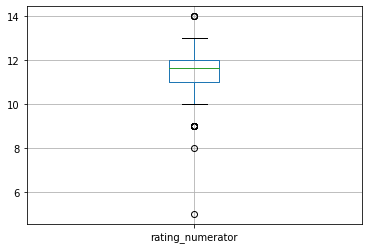

In [134]:
# BOXPLOT Figure:
# 1- Rating Numerator:
tw_archive_master.boxplot(column = ["rating_numerator"]);

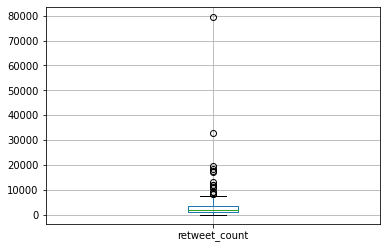

In [127]:
# BOXPLOT Figure:
# 2- Retweet Count:
tw_archive_master.boxplot(column = ["retweet_count"]);

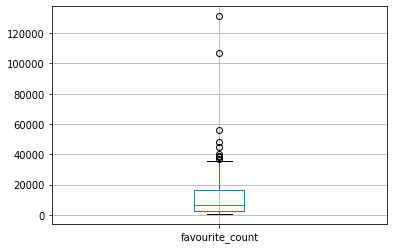

In [128]:
# BOXPLOT Figure:
# 3- Favourite Count:
tw_archive_master.boxplot(column = ["favourite_count"]);

> ## PART II: Analysis and Insights:
>- ### Favourite Dogs Name, Breed and Stage during the period 03/12/2015 to 25/07/2017

In [129]:
# Sorting DataFrame accoring to the timestamp ascendingly
tw_archive_master = tw_archive_master.sort_values(by = ["timestamp"])

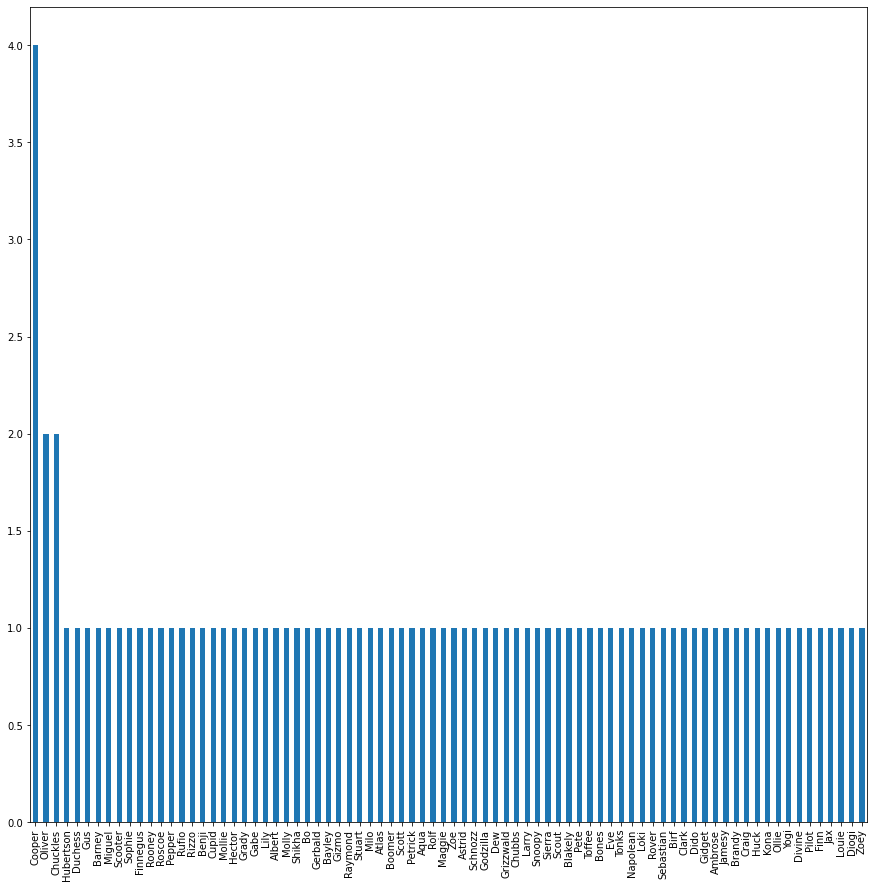

In [166]:
# Favourite Dog Name:
dog_name_count_table = tw_archive_master.dog_name.value_counts()
dog_name_count_table.plot.bar(figsize = (15, 15));

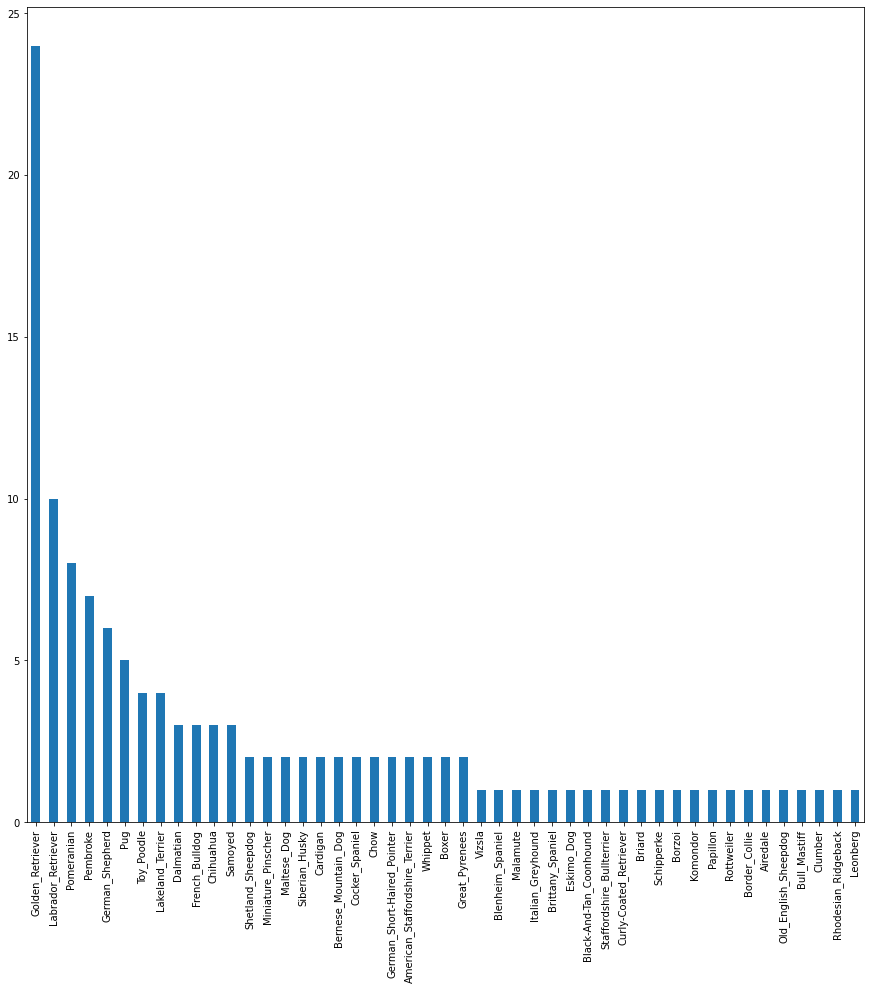

In [169]:
# Favourite Dog Breed:
dog_breed_count_table = tw_archive_master.dog_breed_image_prediction_result.value_counts()
dog_breed_count_table.plot.bar(figsize = (15, 15));

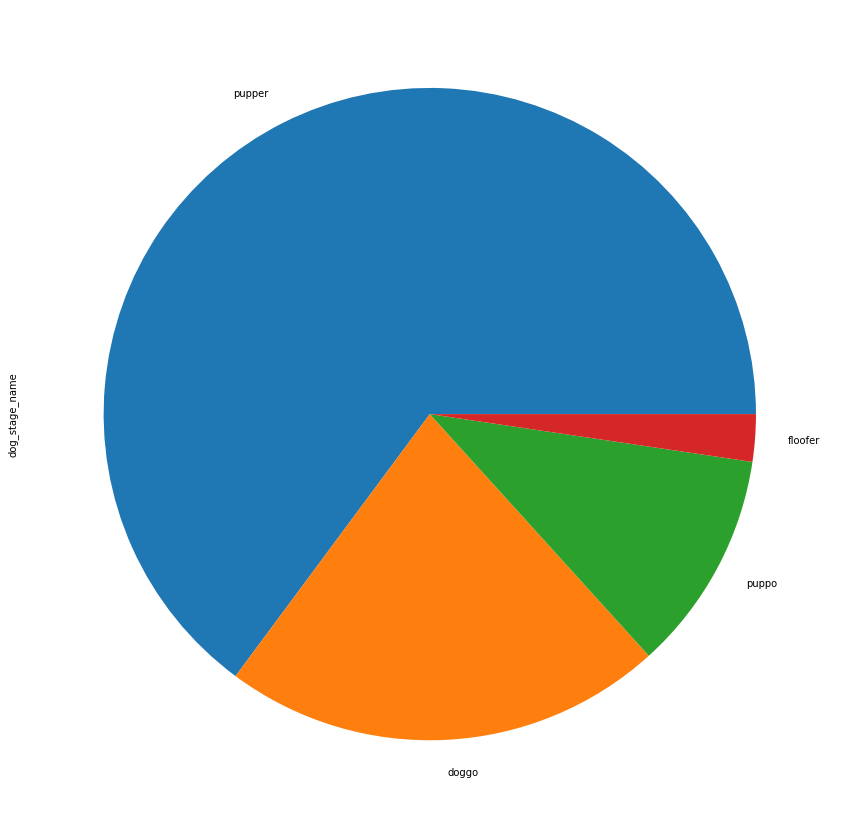

In [172]:
# Favourite Dog Stage:
dog_stage_count_table = tw_archive_master.dog_stage_name.value_counts()
dog_stage_count_table.plot.pie(figsize = (15, 15));

> ## PART II: Analysis and Insights:
>- ### Retweet and Favourite counts timeseries during the period 03/12/2015 to 25/07/2017

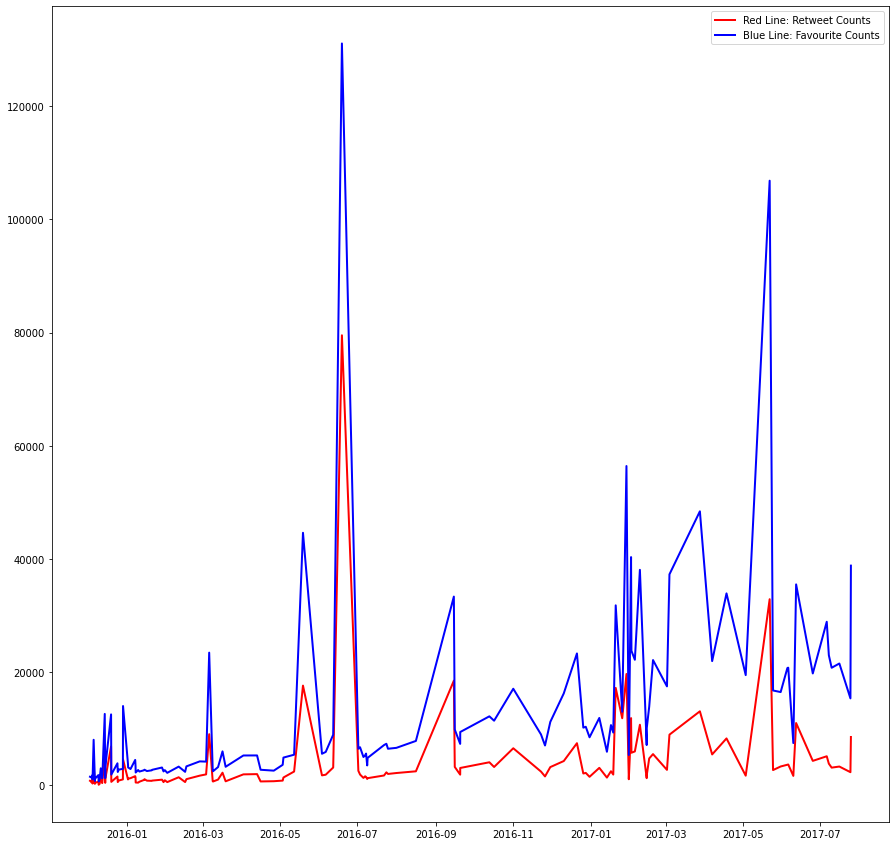

In [182]:
x_axis = tw_archive_master.timestamp
y_axis = tw_archive_master.retweet_count
y2_axis = tw_archive_master.favourite_count
plt.figure(figsize = (15, 15));
plt.plot(x_axis, y_axis, color = "red", linewidth = 2);
plt.plot(x_axis, y2_axis, color = "blue", linewidth = 2);
plt.legend(("Red Line: Retweet Counts", "Blue Line: Favourite Counts"));

> ## PART II: Analysis and Insights:
>- ### Scatter Plot between Retweet Counts on the x-axis and Favourite Counts on the y-axis during the period 03/12/2015 to 25/07/2017

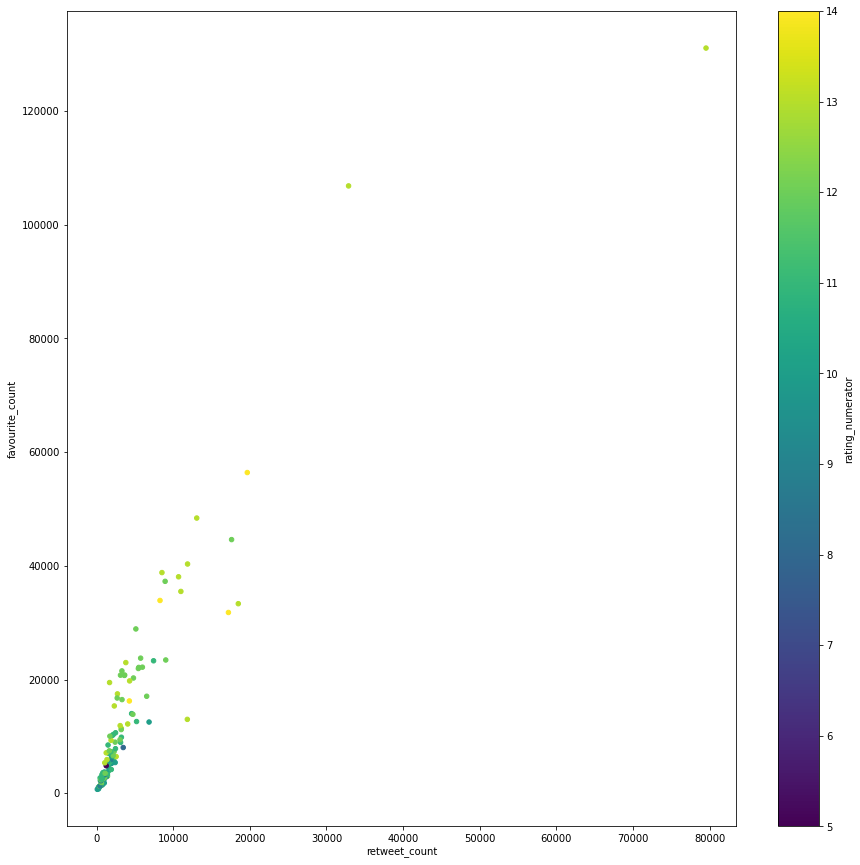

In [187]:
fig, ax = plt.subplots();
tw_archive_master.plot.scatter(x = "retweet_count", y = "favourite_count", c = "rating_numerator",colormap = "viridis", figsize = (15, 15), ax = ax);

> ## PART II: Analysis and Insights:
>- ### Maximum Counts for Retweet and Favourite Dogs during 03/12/2015 to 25/07/2017

In [188]:
tw_archive_master[tw_archive_master.retweet_count ==max(tw_archive_master.retweet_count)]

,tweet_id,timestamp,text,rating_numerator,rating_denominator,dog_name,dog_stage_name,jpg_url,img_num,dog_breed_image_prediction_result,dog_breed_image_prediction_confidence_interval,is_image_prediction_result_a_dog_breed,retweet_count,favourite_count
23,744234799360020481,2016-06-18 18:26:18+00:00,Here's a doggo realizing you can stand in a po...,13.0,10,NaN,doggo,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1,Labrador_Retriever,0.825333,True,79515,131075
